In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torch_geometric torch_sparse torch_scatter

### Import libraries

In [3]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import os.path as osp 
import matplotlib
import matplotlib.pyplot as plt
 
import tqdm.notebook as tqdm
from multiprocessing.pool import Pool
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import time
import torch
import torch.nn.functional as F
from torch.nn import Linear, LogSoftmax 

from torch_geometric.loader import DataLoader
from torch_geometric.profile import get_model_size, get_data_size, count_parameters, profileit, timeit
from torch_geometric.nn import GATConv, GCNConv, GINConv, GraphConv, global_add_pool, global_mean_pool


from sklearn.metrics import classification_report
from torch_geometric.data import InMemoryDataset
from torch_geometric.io import read_tu_data

### Create Graphs Dataset

In [5]:
class GraphDataset(InMemoryDataset):
    def __init__(self, root, name, transform=None, pre_transform=None,
                 pre_filter=None, use_node_attr=False, use_edge_attr=False):
        self.name = name
        super(GraphDataset, self).__init__(root, transform, pre_transform, pre_filter)
        print('=======================================================')
        print(self.processed_paths[0])
        print('=======================================================')
        self.data, self.slices = torch.load(self.processed_paths[0]) 
        
    @property
    def raw_dir(self):
        name = 'raw{}'.format('')
        return osp.join(self.root, self.name, name)

    @property
    def processed_dir(self):
        name = 'processed{}'.format('')
        return osp.join(self.root, self.name, name)

    @property
    def num_node_labels(self):
        if self.data.x is None:
            return 0
        for i in range(self.data.x.size(1)):
            x = self.data.x[:, i:]
            if ((x == 0) | (x == 1)).all() and (x.sum(dim=1) == 1).all():
                return self.data.x.size(1) - i
        return 0

    @property
    def num_node_attributes(self):
        if self.data.x is None:
            return 0
        return self.data.x.size(1) - self.num_node_labels

    @property
    def num_edge_labels(self):
        if self.data.edge_attr is None:
            return 0
        for i in range(self.data.edge_attr.size(1)):
            if self.data.edge_attr[:, i:].sum() == self.data.edge_attr.size(0):
                return self.data.edge_attr.size(1) - i
        return 0

    @property
    def num_edge_attributes(self):
        if self.data.edge_attr is None:
            return 0
        return self.data.edge_attr.size(1) - self.num_edge_labels

    @property
    def raw_file_names(self):
        names = ['A', 'graph_indicator','graph_labels','node_attributes','node_labels']
        return ['{}_{}.txt'.format(self.name, name) for name in names]

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        print('Self - raw_dir: ', self.raw_dir) 
        print('Self - name: ', self.name)
        self.data, self.slices = read_tu_data(self.raw_dir, self.name)
        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [self.pre_transform(data) for data in data_list]
            self.data, self.slices = self.collate(data_list)

        torch.save((self.data, self.slices), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format(self.name, len(self))



```
def parse_txt_array(src, sep=None, start=0, end=None, dtype=None, device=None):
    to_number = int
    if torch.is_floating_point(torch.empty(0, dtype=dtype)):
        to_number = float

    __src__ = []   
    for line in src: 
        __arr__ = []  
        for x in line.split(sep)[start:end]:
            try: 
                __arr__.append(to_number(x))
            except: 
                __arr__.append(0)
        __src__.append(__arr__)  
    src = torch.tensor(__src__).to(dtype).squeeze()
    return src
```



In [6]:
root = '/content/drive/MyDrive/COURSES/CS331/FinalProject/dataset/GraphCXR/CXR_Reformat_128_CXR_Prewitt/'
name_dataset = 'CXR_Reformat_128_CXR_Prewitt_Trainv2'

dataset_train = GraphDataset(root=root, name=name_dataset, use_node_attr=True) 
 
print(f'Dataset name: {dataset_train}:')
print('==================')
print(f'Number of graphs: {len(dataset_train)}')
print(f'Number of features: {dataset_train.num_features}')
print(f'Number of classes: {dataset_train.num_classes}')

/content/drive/MyDrive/COURSES/CS331/FinalProject/dataset/GraphCXR/CXR_Reformat_128_CXR_Prewitt/CXR_Reformat_128_CXR_Prewitt_Trainv2/processed/data.pt
Dataset name: CXR_Reformat_128_CXR_Prewitt_Trainv2(4022):
Number of graphs: 4022
Number of features: 4
Number of classes: 3


In [7]:
root = '/content/drive/MyDrive/COURSES/CS331/FinalProject/dataset/GraphCXR/CXR_Reformat_128_CXR_Prewitt/'
name_dataset = 'CXR_Reformat_128_CXR_Prewitt_Valv2'

dataset_test = GraphDataset(root=root, name=name_dataset, use_node_attr=True) 
 
print(f'Dataset name: {dataset_test}:')
print('==================')
print(f'Number of graphs: {len(dataset_test)}')
print(f'Number of features: {dataset_test.num_features}')
print(f'Number of classes: {dataset_test.num_classes}')

/content/drive/MyDrive/COURSES/CS331/FinalProject/dataset/GraphCXR/CXR_Reformat_128_CXR_Prewitt/CXR_Reformat_128_CXR_Prewitt_Valv2/processed/data.pt
Dataset name: CXR_Reformat_128_CXR_Prewitt_Valv2(994):
Number of graphs: 994
Number of features: 4
Number of classes: 3


In [8]:
root = '/content/drive/MyDrive/COURSES/CS331/FinalProject/dataset/GraphCXR/CXR_Reformat_128_CXR_Prewitt/'
name_dataset = 'CXR_Reformat_128_CXR_Prewitt_Testv2'

dataset_val = GraphDataset(root=root, name=name_dataset, use_node_attr=True) 
 
print(f'Dataset name: {dataset_val}:')
print('==================')
print(f'Number of graphs: {len(dataset_val)}')
print(f'Number of features: {dataset_val.num_features}')
print(f'Number of classes: {dataset_val.num_classes}')

/content/drive/MyDrive/COURSES/CS331/FinalProject/dataset/GraphCXR/CXR_Reformat_128_CXR_Prewitt/CXR_Reformat_128_CXR_Prewitt_Testv2/processed/data.pt
Dataset name: CXR_Reformat_128_CXR_Prewitt_Testv2(614):
Number of graphs: 614
Number of features: 4
Number of classes: 3


In [9]:
torch.manual_seed(12345)
dataset_train = dataset_train.shuffle() 
dataset_val = dataset_val.shuffle() 

train_dataset = dataset_train[:]
val_dataset = dataset_val[:]
test_dataset = dataset_test[:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 115414], x=[25148, 4], y=[64], batch=[25148], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 113054], x=[24421, 4], y=[64], batch=[24421], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 121800], x=[27697, 4], y=[64], batch=[27697], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 124612], x=[27255, 4], y=[64], batch=[27255], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 109608], x=[23622, 4], y=[64], batch=[23622], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 101950], x=[22579, 4], y=[64], batch=[22579], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 105660], x=[24244, 4], y=[64], batch=[24244], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1

### Build GCN & GNN Model

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, num_classes, hidden_dim, node_features_dim, edge_features_dim=None):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(node_features_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)
        self.conv5 = GCNConv(hidden_dim, hidden_dim)
        self.lin = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


class GNN(torch.nn.Module):
    def __init__( self, num_classes, hidden_dim, node_features_dim, edge_features_dim=None ):
        super(GNN, self).__init__()
        self.hidden_dim = hidden_dim

        self.conv1 = GraphConv(node_features_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.conv4 = GraphConv(hidden_dim, hidden_dim)
        self.conv5 = GraphConv(hidden_dim, hidden_dim)

        self.fc1 = Linear(hidden_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return self.readout(x)

In [11]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print("**************************")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = GNN(num_classes=dataset_train.num_classes, hidden_dim=64, node_features_dim=dataset_train.num_node_features).to(device)

print('*****Model size is: ', get_model_size(model))
print("=====Model parameters are: ", count_parameters(model)) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

Number of training graphs: 4022
Number of val graphs: 614
Number of test graphs: 994
**************************
*****Model size is:  157548
=====Model parameters are:  37955


In [12]:
def plot_cm(cm, display_labels= ['BIRAD_0', 'BIRAD_1', 'BIRAD_2', 'BIRAD_3','BIRAD_4A', 'BIRAD_4B','BIRAD_4C', 'BIRAD_5']):
 
    # Set fontsize for plots
    font = {"size": 20}
    matplotlib.rc("font", **font)

    # Plot confusion matrix
    f, axes = plt.subplots(1, 1, figsize=(7, 7), sharey="row")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=axes, xticks_rotation=45, cmap="Blues", values_format='d')
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("Predicted label", fontsize=20)
    disp.ax_.set_ylabel("True label", fontsize=20)
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.show()

In [13]:
train_losses, val_losses = [], [] 

def train():
    model.train() 
    total_loss = 0.0
    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        label = data.y
 
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass. 
        loss = criterion(out, data.y)  # Compute the loss.
        total_loss = torch.sum(loss) + total_loss  
        loss.backward()  # Derive gradients. 
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    print('Train loss:', (float)(total_loss))
    train_losses.append((float)(total_loss))
    # return total_loss 

#@timeit()
def test(loader, is_up = True):
    model.eval()
    correct = 0
    y_pred = []
    y_true = []
    total_loss = 0.0
    for data in loader:   
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  

        loss = criterion(out, data.y)
        total_loss = torch.sum(loss) + total_loss 

        pred = out.argmax(dim=1)  
        correct += int((pred == data.y).sum())   

        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(np.squeeze(pred.cpu().numpy().T))
    # report = classification_report(y_true, y_pred, digits=4) 
    if is_up == True: 
        print('Val loss:', (float)(total_loss))
        val_losses.append((float)(total_loss))
    return correct / len(loader.dataset) # , total_loss


def inference(loader):
    model.eval()
    correct = 0
    y_pred = []
    y_true = []
    for data in tqdm.tqdm(loader):
        data = data.to('cpu')
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  
        print('==============')
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(np.squeeze(pred.cpu().numpy().T))
    report = classification_report(y_true, y_pred, digits=4)
    cm = confusion_matrix(y_true, y_pred)
    display_labels = ['Bacteria', 'Normal', 'Virus']
    plot_cm(cm=cm, display_labels=display_labels)    

    return correct / len(loader.dataset)

In [14]:
num_epochs = 500
start = time.time()
best_val_acc = 0.9
train_accs, val_accs = [], []
train_losses, val_losses = [], [] 

for epoch in tqdm.tqdm(range(0, num_epochs)):
    train()
    train_acc = test(train_loader, is_up = False)
    val_acc = test(val_loader, is_up = True)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_weight_path = osp.join(f"GNN_" + name_dataset + "_best" + ".pth")
        print('New best model saved to:', save_weight_path)
        torch.save(model.state_dict(), save_weight_path)

    # if epoch % 10 == 0:
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}')
    
    train_accs.append(train_acc)
    # train_losses.append(train_loss) 

    val_accs.append(val_acc)
    # val_losses.append(val_loss)

  0%|          | 0/500 [00:00<?, ?it/s]

Train loss: 26745.9609375
Val loss: 660.9125366210938
New best model saved to: GNN_CXR_Reformat_128_CXR_Prewitt_Testv2_best.pth
Epoch: 000, Train Acc: 0.9709, Validation Acc: 0.9707
Train loss: 4260.84912109375
Val loss: 516.7020263671875
Epoch: 001, Train Acc: 0.9739, Validation Acc: 0.9707
Train loss: 2661.66259765625
Val loss: 454.8880310058594
Epoch: 002, Train Acc: 0.9741, Validation Acc: 0.9707
Train loss: 1900.03759765625
Val loss: 403.0007629394531
New best model saved to: GNN_CXR_Reformat_128_CXR_Prewitt_Testv2_best.pth
Epoch: 003, Train Acc: 0.9739, Validation Acc: 0.9723
Train loss: 1293.9578857421875
Val loss: 370.2259216308594
Epoch: 004, Train Acc: 0.9739, Validation Acc: 0.9723
Train loss: 980.3457641601562
Val loss: 347.3230285644531
Epoch: 005, Train Acc: 0.9739, Validation Acc: 0.9707
Train loss: 624.36279296875
Val loss: 305.7716064453125
Epoch: 006, Train Acc: 0.9739, Validation Acc: 0.9691
Train loss: 477.5736999511719
Val loss: 324.3023376464844
Epoch: 007, Train 

In [15]:
print(train_accs)

[0.9709099950273495, 0.9738935852809547, 0.9741422178020885, 0.9738935852809547, 0.9738935852809547, 0.9738935852809547, 0.9738935852809547, 0.9679264047737444, 0.9699154649428146, 0.9699154649428146, 0.9674291397314769, 0.9674291397314769, 0.9614619592242666, 0.9689209348582795, 0.9664346096469418, 0.9641969169567379, 0.9530084535057185, 0.9549975136747887, 0.9614619592242666, 0.9358528095474888, 0.8483341621084037, 0.8530581800099453, 0.8679761312779711, 0.8446046742913973, 0.8729487817006465, 0.8781700646444555, 0.8779214321233217, 0.9067628045748384, 0.8423669816011934, 0.8336648433615117, 0.8756837394331178, 0.8679761312779711, 0.8980606663351567, 0.8774241670810542, 0.8896071606166086, 0.8856290402784684, 0.894579811039284, 0.8970661362506216, 0.9132272501243163, 0.9333664843361512, 0.9343610144206862, 0.9351069119840875, 0.9582297364495276, 0.9617105917454003, 0.951516658378916, 0.9525111884634511, 0.9706613625062158, 0.9701640974639483, 0.9684236698160119, 0.9679264047737444, 0

In [16]:
print(val_accs)

[0.9706840390879479, 0.9706840390879479, 0.9706840390879479, 0.9723127035830619, 0.9723127035830619, 0.9706840390879479, 0.9690553745928339, 0.9657980456026058, 0.9641693811074918, 0.9674267100977199, 0.9657980456026058, 0.9641693811074918, 0.9560260586319218, 0.9674267100977199, 0.9657980456026058, 0.9609120521172638, 0.9527687296416938, 0.9478827361563518, 0.9560260586319218, 0.9185667752442996, 0.8224755700325733, 0.8403908794788274, 0.8599348534201955, 0.8273615635179153, 0.8517915309446255, 0.8615635179153095, 0.8648208469055375, 0.8990228013029316, 0.8208469055374593, 0.8159609120521173, 0.8664495114006515, 0.8680781758957655, 0.9071661237785016, 0.8811074918566775, 0.9039087947882736, 0.9022801302931596, 0.9071661237785016, 0.9055374592833876, 0.9299674267100977, 0.9429967426710097, 0.9446254071661238, 0.9429967426710097, 0.9657980456026058, 0.9625407166123778, 0.9625407166123778, 0.9592833876221498, 0.9657980456026058, 0.9657980456026058, 0.9657980456026058, 0.9657980456026058,

In [17]:
print(val_losses)

[660.9125366210938, 516.7020263671875, 454.8880310058594, 403.0007629394531, 370.2259216308594, 347.3230285644531, 305.7716064453125, 324.3023376464844, 305.1994934082031, 310.1129455566406, 319.08160400390625, 292.1357421875, 345.5818176269531, 362.4306640625, 295.3589172363281, 301.8414001464844, 304.9920349121094, 299.0663757324219, 296.0998229980469, 305.1444091796875, 316.06170654296875, 302.4713134765625, 285.63641357421875, 286.564697265625, 286.8572082519531, 350.71728515625, 287.5487976074219, 287.2823791503906, 298.6003112792969, 291.8998107910156, 281.1280822753906, 328.7937927246094, 294.3521728515625, 296.1820983886719, 281.4567565917969, 331.7198791503906, 280.7315673828125, 283.5914001464844, 281.52850341796875, 332.52008056640625, 306.86737060546875, 304.8620300292969, 298.528564453125, 303.17315673828125, 348.14141845703125, 348.5089416503906, 301.0387268066406, 342.4584655761719, 375.135986328125, 315.1614074707031, 297.37261962890625, 295.02655029296875, 299.16485595

In [18]:
print(train_losses)

[26745.9609375, 4260.84912109375, 2661.66259765625, 1900.03759765625, 1293.9578857421875, 980.3457641601562, 624.36279296875, 477.5736999511719, 320.51788330078125, 217.7150115966797, 181.69700622558594, 165.90663146972656, 79.41962432861328, 57.76284408569336, 56.6057014465332, 42.00975799560547, 23.255964279174805, 22.36056137084961, 26.709260940551758, 18.403564453125, 20.680160522460938, 13.788268089294434, 26.315088272094727, 16.037010192871094, 13.723410606384277, 13.403890609741211, 14.230494499206543, 12.616652488708496, 12.953502655029297, 11.969417572021484, 11.920855522155762, 11.876898765563965, 12.463939666748047, 11.539228439331055, 12.310253143310547, 10.899442672729492, 11.499069213867188, 11.812355995178223, 11.055170059204102, 13.0247220993042, 12.982739448547363, 12.623580932617188, 11.282968521118164, 10.53663158416748, 10.274467468261719, 10.133371353149414, 11.424302101135254, 11.066484451293945, 13.918051719665527, 9.755294799804688, 11.390628814697266, 9.8140611

Total training time to train on GPU (min): 23.438585154215495
=======End training process here======


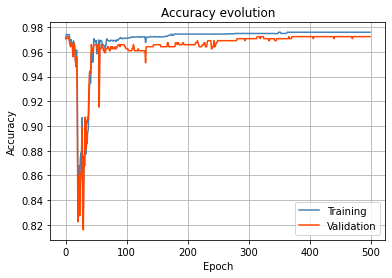

In [19]:
fig, ax = plt.subplots()
ax.plot(train_accs, c="steelblue", label="Training")
ax.plot(val_accs, c="orangered", label="Validation")
# ax.plot(train_accs, c="steelblue", label="Training")
# ax.plot(val_accs, c="orangered", label="Validation")
ax.grid()
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')
ax.set_title("Accuracy evolution")
#plt.show()
plt.savefig(f"Evolution_training_GNN_" + name_dataset + ".png")

end = time.time()
time_to_train = (end - start)/60
print("Total training time to train on GPU (min):", time_to_train)
print("=======End training process here======")

In [20]:
# Inference test set
print("******Start inference on test set******")
start_2 = time.time()
inference(test_loader)
end_2 = time.time()
time_to_train_2 = (end_2 - start_2)/60
print("Total Inference time to train on GPU (min):", time_to_train_2)

print("*****===== EVERYTHING WORKED FINE AND FINISHED HERE !!!!!!!!!!!=====*****") 

******Start inference on test set******


  0%|          | 0/16 [00:00<?, ?it/s]

RuntimeError: ignored